In [1]:
%run ../../../shared_setup.ipynb

docker image cggh/biipy:v1.6.0


In [2]:
truth_dir = '/data/plasmodium/pfalciparum/pf-crosses/data/evaluation/truth'

In [3]:
gatk_callset_fn_template = '/data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/{cross}.gatk.final.npz'

In [4]:
def trim_alleles(a, b):

    # SNPs or already trimmed
    if len(a) == 1 or len(b) == 1:
        return a, b
    
    # sort by length, shortest first
    reverse = False
    if len(a) > len(b):
        a, b = b, a
        reverse = True
    
    # pick off reference base
    ref_base = a[0]
    assert a[0] == b[0], (a, b)
    
    # pick off suffix
    a_suffix = a[1:]
    b_suffix = b[1:]
    
    # trim
    if b_suffix.endswith(a_suffix):
        a = ref_base
        b = ref_base + b_suffix[:-1*len(a_suffix)]
        
    if reverse:
        return b, a
    else:
        return a, b 

In [5]:
def tabulate_variants_gatk(cross, parent):

    callset_gatk = np.load(gatk_callset_fn_template.format(cross=cross))
    variants = callset_gatk['variants']

    # select variants
    filter_condition = numexpr.evaluate('~FILTER_CNV & '
                                        '~FILTER_DUP_SITE & '
                                        '~FILTER_LOW_CONFIDENCE & '
                                        '~FILTER_LOW_CONFIDENCE_PARENT & '
                                        '~FILTER_MISSING_PARENT & '
                                        '~FILTER_NON_CORE & '
                                        '~FILTER_NON_MENDELIAN',
                                        local_dict=variants)
    log(callset_gatk['calldata'].dtype.names[parent])
    c2d = vcfnp.view2d(callset_gatk['calldata'])
    genotype = c2d['genotype']
    genotype_parent = genotype[:, parent]
    genotype_condition = genotype_parent > 0
    condition = filter_condition & genotype_condition
    log('n_variants', nnz(condition))

    # apply selection
    variants = np.compress(condition, variants)
    genotype_parent = np.compress(condition, genotype_parent)
    
    # construct table
    tbl = (etl
        .fromarray(variants)
        .addcolumn('genotype', genotype_parent)
        .cut('CHROM', 'POS', 'REF', 'ALT', 'genotype')
        .convert('ALT', lambda v, row: v[row.genotype-1], pass_row=True)
        .cutout('genotype')
        .convert(['CHROM', 'REF', 'ALT'], lambda v: str(v, 'ascii')) 
        .addfield('svlen', lambda row: len(row.ALT) - len(row.REF))
        .addfield('trim', lambda row: trim_alleles(row.REF, row.ALT))
        .unpack('trim', ['REF_trim', 'ALT_trim'])
        .addfield('svlen_trim', lambda row: len(row.ALT_trim) - len(row.REF_trim))
        .cutout('REF', 'ALT', 'svlen')
        .rename({'REF_trim': 'REF', 'ALT_trim': 'ALT', 'svlen_trim': 'svlen'})
        .addfield('svtype', lambda row: 'SNP' if row.svlen == 0 else 'INS' if row.svlen > 0 else 'DEL')
        .addfield('discovery', True)
    )
    
    return tbl


In [6]:
def load_coverage(alignment_method, assembly, rebuild=False):
    bam_fn = os.path.join(truth_dir, alignment_method, 'alignment', assembly + '.bam')
    cov_fn = bam_fn + '.coverage.npy'
    if not os.path.exists(cov_fn) or rebuild:
        cov = pysamstats.load_coverage(bam_fn, 
                                       pad=True, 
                                       fields=['chrom', 'pos', 'reads_all'],
                                       one_based=True)
        np.save(cov_fn, cov)
    else:
        cov = np.load(cov_fn).view(np.recarray)
    return cov

In [7]:
def tabulate_variants_truth(alignment_method, calling_method, assembly):
    truth_vcf_fn = os.path.join(truth_dir, alignment_method, 'calling', calling_method, assembly + '.leftaligned.vcf.gz')

    # extract variants
    truth_variants = vcfnp.variants(truth_vcf_fn, 
                                    fields=['CHROM', 'POS', 'REF', 'ALT'],
                                    dtypes={'REF': 'S200', 'ALT': 'S200'},
                                    arities={'ALT': 4},
                                    cache=False)
    
    # extract genotype
    truth_genotype = vcfnp.calldata_2d(truth_vcf_fn, 
                                       fields=['genotype'], 
                                       ploidy=1,
                                       cache=False)['genotype'][:, 0]
    
    # tabulate
    tbl = (etl
        .fromarray(truth_variants)
        .addcolumn('genotype', truth_genotype)
        .convert('ALT', lambda v, row: v[row.genotype-1], pass_row=True)
        .cutout('genotype')
        .convert(['CHROM', 'REF', 'ALT'], lambda v: str(v, 'ascii')) 
        .addfield('svlen', lambda row: len(row.ALT) - len(row.REF))
        .addfield('trim', lambda row: trim_alleles(row.REF, row.ALT))
        .unpack('trim', ['REF_trim', 'ALT_trim'])
        .addfield('svlen_trim', lambda row: len(row.ALT_trim) - len(row.REF_trim))
        .cutout('REF', 'ALT', 'svlen')
        .rename({'REF_trim': 'REF', 'ALT_trim': 'ALT', 'svlen_trim': 'svlen'})
        .intervalleftjoin(tbl_regions_1b, lkey='CHROM', rkey='region_chrom',
                          lstart='POS', lstop='POS', rstart='region_start', rstop='region_stop',
                          include_stop=True)
        .eq('region_type', 'Core')
        .cutout('region_chrom', 'region_start', 'region_stop', 'region_type', 'region_size')
        .addfield('svtype', lambda row: 'SNP' if row.svlen == 0 else 'INS' if row.svlen > 0 else 'DEL')
        .addfield('truth', True)
    )

    return tbl

In [12]:
def join_truth(tbl_discovery, alignment_method, calling_method, assembly, key=('CHROM', 'POS')):
    
    # tabulate truth variants
    tbl_truth = tabulate_variants_truth(alignment_method, calling_method, assembly)
    
    # load coverage from truth assembly
    cov = load_coverage(alignment_method, assembly)
    cov_idx = allel.SortedMultiIndex(cov['chrom'], cov['pos'], copy=False)
#     tbl_cov = etl.fromarray(cov).convert('chrom', lambda v: str(v, 'ascii')).rename({'chrom': 'CHROM', 'pos': 'POS'})
    
    # tabulate
    tbl = (
        tbl_discovery
        .outerjoin(tbl_truth, key=key, rprefix='truth_')
        .rename('truth_truth', 'truth')
        .addfield('truth_coverage', lambda row: cov.reads_all[cov_idx.locate_key(row.CHROM.encode('ascii'), row.POS)])
        .eq('truth_coverage', 1)
        .addfield('status', lambda row: 'FP' if row.truth is None else 'FN' if row.discovery is None else 'TP')
        .cutout('discovery', 'truth')
        .intervaljoinvalues(tbl_genes, value='feature_id', lkey='CHROM', lstart='POS', lstop='POS', 
                            rkey='feature_chrom', rstart='feature_start', rstop='feature_stop', include_stop=True)
        .rename('feature_id', 'gene')
        .convert('gene', lambda v: v[0] if v else None)
        .intervaljoinvalues(tbl_exons, value='feature_id', lkey='CHROM', lstart='POS', lstop='POS', 
                            rkey='feature_chrom', rstart='feature_start', rstop='feature_stop', include_stop=True)
        .rename('feature_id', 'is_coding')
        .convert('is_coding', lambda v: len(v) > 0)
        .cache(100000)
    )
    
    return tbl

In [13]:
def analyse_confusion(tbl_joined):
    
    df = tbl_joined.cut('svtype', 'truth_svtype', 'status', 'is_coding').todataframe()
    status = df.status
    is_coding = df.is_coding
    is_snp = (df.svtype == 'SNP')
    is_indel = (df.svtype == 'INS') | (df.svtype == 'DEL')
    is_truth_snp = (df.truth_svtype == 'SNP')
    is_truth_indel = (df.truth_svtype == 'INS') | (df.truth_svtype == 'DEL')
    
    tbl_confusion = [['svtype', 'n', 'TP', 'FP', 'FN', 'FDR', 'sensitivity']]
    
    fig = plt.figure(figsize=(8, 6))

    # all variants analyse confusion
    fp = nnz(status == 'FP')
    fn = nnz(status == 'FN')
    tp = nnz(status == 'TP')
    n = fp + fn + tp
    fdr = fp / (fp + tp) if (fp + tp) > 0 else 0
    sens = tp / (fn + tp) if (fn + tp) > 0 else 0
    tbl_confusion.append(['all', n, tp, fp, fn, fdr, sens])
    
    # coding SNP analyse confusion
    fp = nnz(is_coding & is_snp & (status == 'FP'))
    fn = nnz(is_coding & is_truth_snp & (status == 'FN'))
    tp = nnz(is_coding & is_snp & (status == 'TP'))
    n = fp + fn + tp
    fdr = fp / (fp + tp) if (fp + tp) > 0 else 0
    sens = tp / (fn + tp) if (fn + tp) > 0 else 0
    tbl_confusion.append(['SNP coding', n, tp, fp, fn, fdr, sens])
    from matplotlib_venn import venn2
    ax = fig.add_subplot(2, 2, 1)
    v = venn2(subsets=[fp, fn, tp], set_labels=['discovery', 'truth'], ax=ax)
    v.get_patch_by_id('10').set_color('#ff4444')
    v.get_patch_by_id('01').set_color('#4444ff')
    plt.gca().set_title('SNP coding')
    
    # non-coding SNP analyse confusion
    fp = nnz(~is_coding & is_snp & (status == 'FP'))
    fn = nnz(~is_coding & is_truth_snp & (status == 'FN'))
    tp = nnz(~is_coding & is_snp & (status == 'TP'))
    n = fp + fn + tp
    fdr = fp / (fp + tp) if (fp + tp) > 0 else 0
    sens = tp / (fn + tp) if (fn + tp) > 0 else 0
    tbl_confusion.append(['SNP non-coding', n, tp, fp, fn, fdr, sens])
    from matplotlib_venn import venn2
    ax = fig.add_subplot(2, 2, 2)
    v = venn2(subsets=[fp, fn, tp], set_labels=['discovery', 'truth'], ax=ax)
    v.get_patch_by_id('10').set_color('#ff4444')
    v.get_patch_by_id('01').set_color('#4444ff')
    plt.gca().set_title('SNP non-coding')
    
    # coding INDEL analyse confusion
    fp = nnz(is_coding & is_indel & (status == 'FP'))
    fn = nnz(is_coding & is_truth_indel & (status == 'FN'))
    tp = nnz(is_coding & is_indel & (status == 'TP'))
    n = fp + fn + tp
    fdr = fp / (fp + tp) if (fp + tp) > 0 else 0
    sens = tp / (fn + tp) if (fn + tp) > 0 else 0
    tbl_confusion.append(['INDEL coding', n, tp, fp, fn, fdr, sens])
    from matplotlib_venn import venn2
    ax = fig.add_subplot(2, 2, 3)
    v = venn2(subsets=[fp, fn, tp], set_labels=['discovery', 'truth'], ax=ax)
    v.get_patch_by_id('10').set_color('#ff4444')
    v.get_patch_by_id('01').set_color('#4444ff')
    plt.gca().set_title('INDEL coding')
    
    # non-coding INDEL analyse confusion
    fp = nnz(~is_coding & is_indel & (status == 'FP'))
    fn = nnz(~is_coding & is_truth_indel & (status == 'FN'))
    tp = nnz(~is_coding & is_indel & (status == 'TP'))
    n = fp + fn + tp
    fdr = fp / (fp + tp) if (fp + tp) > 0 else 0
    sens = tp / (fn + tp) if (fn + tp) > 0 else 0
    tbl_confusion.append(['INDEL non-coding', n, tp, fp, fn, fdr, sens])
    from matplotlib_venn import venn2
    ax = fig.add_subplot(2, 2, 4)
    v = venn2(subsets=[fp, fn, tp], set_labels=['discovery', 'truth'], ax=ax)
    v.get_patch_by_id('10').set_color('#ff4444')
    v.get_patch_by_id('01').set_color('#4444ff')
    plt.gca().set_title('INDEL non-coding')
    
    tbl_confusion = etl.wrap(tbl_confusion)
    tbl_confusion.displayall()


In [14]:
def confusion_tr_style(row):
    style = 'background-color: %s' % ('#4f4' if row.status == 'TP' 
                                      else '#f44' if row.status == 'FP'
                                      else '#44f' if row.status == 'FN'
                                      else 'white')
    return style

## 3D7 Illumina assembly - cross-check truth

[vcfnp] 2016-03-08 22:44:04.364898 :: caching is disabled
[vcfnp] 2016-03-08 22:44:04.365488 :: building array
[vcfnp] 2016-03-08 22:44:04.393727 :: caching is disabled
[vcfnp] 2016-03-08 22:44:04.394112 :: building array
[vcfnp] 2016-03-08 22:44:04.449992 :: caching is disabled
[vcfnp] 2016-03-08 22:44:04.450529 :: building array
[vcfnp] 2016-03-08 22:44:04.496156 :: caching is disabled
[vcfnp] 2016-03-08 22:44:04.496652 :: building array
2016-03-08 22:44:09.216125 :: 450


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding
Pf3D7_03_v3,545588,AAAATATATATAAAT,A,-14,DEL,None,None,1,FP,None,False
Pf3D7_04_v3,343440,ACTTTTATTATCGTCAGGTTTG,A,-21,DEL,None,None,1,FP,PF3D7_0406500,True
Pf3D7_04_v3,375115,AATGTAAATGATGAAAATGATGAAAATGATGAAAATGATGAAAATGATGAAAATGATGAAAATGATGAAAATG,A,-72,DEL,None,None,1,FP,PF3D7_0407600,True
Pf3D7_09_v3,184870,GTAATACATATAAAAAATTATTAATATATATATAATAAAA,G,-39,DEL,None,None,1,FP,None,False
Pf3D7_10_v3,1418531,TTTTTTTATATTTTTCTATATTTCTTATATTTTTA,T,-34,DEL,None,None,1,FP,None,False


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding
Pf3D7_01_v3,191069,CA,C,None,None,-1,DEL,1,FN,PF3D7_0104300,True
Pf3D7_01_v3,273111,T,TTATATATATATATATATATATA,None,None,22,INS,1,FN,PF3D7_0106400,False
Pf3D7_01_v3,287205,T,TTATATA,None,None,6,INS,1,FN,PF3D7_0106800,False
Pf3D7_01_v3,288488,A,AT,None,None,1,INS,1,FN,PF3D7_0106800,False
Pf3D7_01_v3,291538,A,AATGAAAAAG,None,None,9,INS,1,FN,PF3D7_0106900,True


0|svtype,1|n,2|TP,3|FP,4|FN,5|FDR,6|sensitivity
all,450,368,6,76,0.016042780748663103,0.8288288288288288
SNP coding,42,34,0,8,0.0,0.8095238095238095
SNP non-coding,219,215,0,4,0.0,0.9817351598173516
INDEL coding,28,17,3,8,0.15,0.68
INDEL non-coding,161,102,3,56,0.02857142857142857,0.6455696202531646


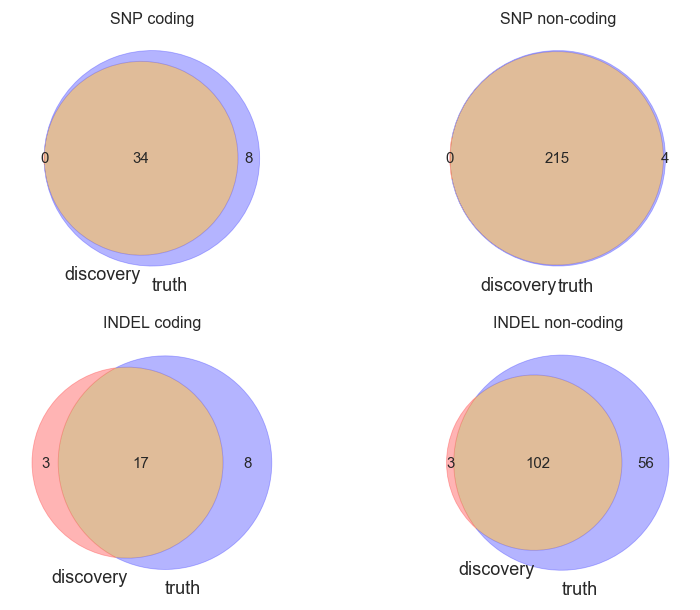

In [15]:
# bwamem_intractg 
# gatk_ug vs bcftools_multiallelic

tbl_variants_check1 = tabulate_variants_truth(alignment_method='bwamem_intractg',
                                              calling_method='gatk_ug',
                                              assembly='garimella_3d7_ERR019061_contigs').cutout('truth').addfield('discovery', True)
tbl_variants_check2 = join_truth(tbl_variants_check1, 
                                 alignment_method='bwamem_intractg',
                                 calling_method='bcftools_multiallelic',
                                 assembly='garimella_3d7_ERR019061_contigs',
                                 key=('CHROM', 'POS', 'REF', 'ALT'))
log(tbl_variants_check2.nrows())
tbl_variants_check2.eq('status', 'FP').display(5, tr_style=confusion_tr_style)
tbl_variants_check2.eq('status', 'FN').display(5, tr_style=confusion_tr_style)
analyse_confusion(tbl_variants_check2)

[vcfnp] 2016-03-08 22:44:10.510801 :: caching is disabled
[vcfnp] 2016-03-08 22:44:10.511466 :: building array
[vcfnp] 2016-03-08 22:44:10.541697 :: caching is disabled
[vcfnp] 2016-03-08 22:44:10.542196 :: building array
[vcfnp] 2016-03-08 22:44:10.601143 :: caching is disabled
[vcfnp] 2016-03-08 22:44:10.601808 :: building array
[vcfnp] 2016-03-08 22:44:10.645569 :: caching is disabled
[vcfnp] 2016-03-08 22:44:10.645963 :: building array


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding
Pf3D7_01_v3,555445,TA,T,-1,DEL,None,None,1,FP,None,False
Pf3D7_02_v3,402926,CA,C,-1,DEL,None,None,1,FP,None,False
Pf3D7_02_v3,827872,GA,G,-1,DEL,None,None,1,FP,None,False
Pf3D7_03_v3,545588,AAAATATATATAAAT,A,-14,DEL,None,None,1,FP,None,False
Pf3D7_03_v3,604213,TA,T,-1,DEL,None,None,1,FP,None,False


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding
Pf3D7_01_v3,273111,T,TTATATATATATATATATATATA,None,None,22,INS,1,FN,PF3D7_0106400,False
Pf3D7_01_v3,287205,T,TTATATA,None,None,6,INS,1,FN,PF3D7_0106800,False
Pf3D7_01_v3,291538,A,AATGAAAAAG,None,None,9,INS,1,FN,PF3D7_0106900,True
Pf3D7_01_v3,294071,C,CATATAT,None,None,6,INS,1,FN,PF3D7_0107000,False
Pf3D7_02_v3,631341,C,CAAAAAAAAAAAAA,None,None,13,INS,1,FN,None,False


0|svtype,1|n,2|TP,3|FP,4|FN,5|FDR,6|sensitivity
all,399,311,63,25,0.16844919786096257,0.9255952380952381
SNP coding,35,34,0,1,0.0,0.9714285714285714
SNP non-coding,215,214,1,0,0.004651162790697674,1.0
INDEL coding,24,8,12,4,0.6,0.6666666666666666
INDEL non-coding,125,55,50,20,0.47619047619047616,0.7333333333333333


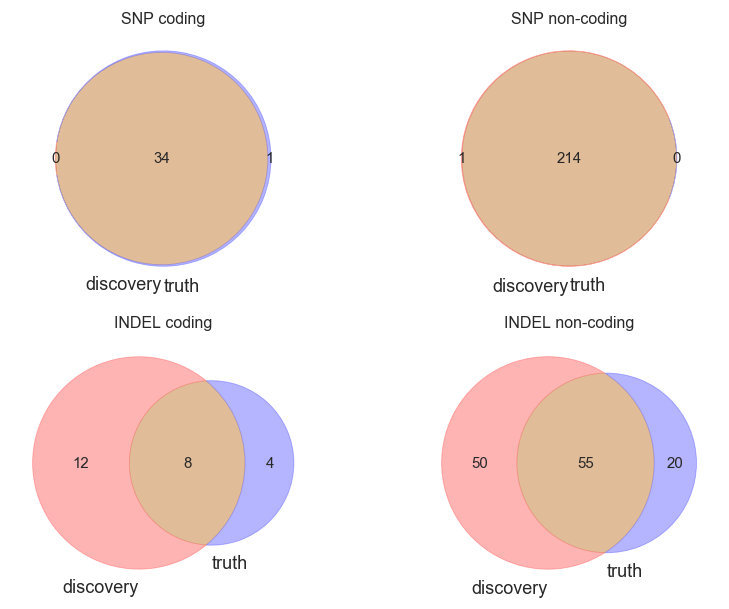

In [16]:
# bwamem_intractg 
# gatk_ug vs bcftools_consensus

tbl_variants_check1 = tabulate_variants_truth(alignment_method='bwamem_intractg',
                                              calling_method='gatk_ug',
                                              assembly='garimella_3d7_ERR019061_contigs').cutout('truth').addfield('discovery', True)
tbl_variants_check2 = join_truth(tbl_variants_check1, 
                                 alignment_method='bwamem_intractg',
                                 calling_method='bcftools_consensus',
                                 assembly='garimella_3d7_ERR019061_contigs',
                                 key=('CHROM', 'POS', 'REF', 'ALT'))
tbl_variants_check2.eq('status', 'FP').display(5, tr_style=confusion_tr_style)
tbl_variants_check2.eq('status', 'FN').display(5, tr_style=confusion_tr_style)
analyse_confusion(tbl_variants_check2)

[vcfnp] 2016-03-08 22:44:15.800168 :: caching is disabled
[vcfnp] 2016-03-08 22:44:15.800721 :: building array
[vcfnp] 2016-03-08 22:44:15.833851 :: caching is disabled
[vcfnp] 2016-03-08 22:44:15.834529 :: building array
[vcfnp] 2016-03-08 22:44:15.889670 :: caching is disabled
[vcfnp] 2016-03-08 22:44:15.890184 :: building array
[vcfnp] 2016-03-08 22:44:15.935920 :: caching is disabled
[vcfnp] 2016-03-08 22:44:15.936373 :: building array


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding
Pf3D7_01_v3,191069,CA,C,None,None,-1,DEL,1,FN,PF3D7_0104300,True
Pf3D7_01_v3,288488,A,AT,None,None,1,INS,1,FN,PF3D7_0106800,False
Pf3D7_01_v3,371593,G,GT,None,None,1,INS,1,FN,None,False
Pf3D7_01_v3,430485,A,AT,None,None,1,INS,1,FN,PF3D7_0111200,False
Pf3D7_01_v3,493069,C,CT,None,None,1,INS,1,FN,None,False


0|svtype,1|n,2|TP,3|FP,4|FN,5|FDR,6|sensitivity
all,444,336,0,108,0.0,0.7567567567567568
SNP coding,42,35,0,7,0.0,0.8333333333333334
SNP non-coding,219,214,0,5,0.0,0.9771689497716894
INDEL coding,25,12,0,13,0.0,0.48
INDEL non-coding,158,75,0,83,0.0,0.47468354430379744


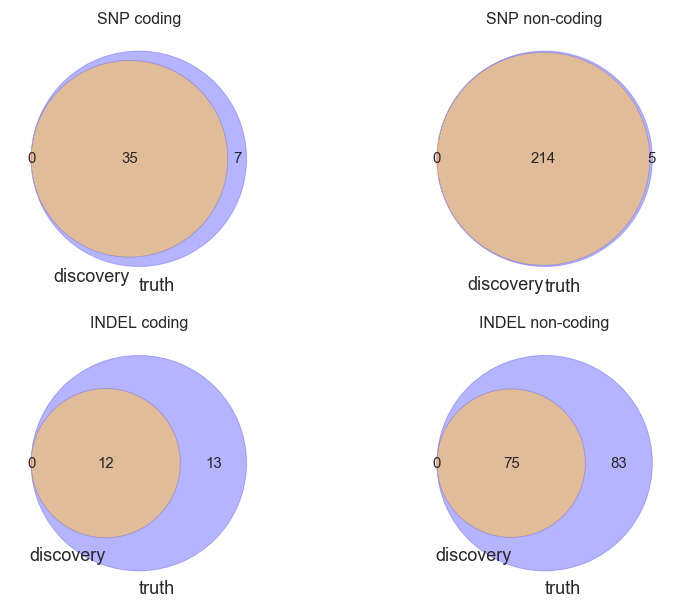

In [17]:
# bwamem_intractg 
# bctfools_consensus vs bcftools_multiallelic

tbl_variants_check1 = tabulate_variants_truth(alignment_method='bwamem_intractg',
                                              calling_method='bcftools_consensus',
                                              assembly='garimella_3d7_ERR019061_contigs').cutout('truth').addfield('discovery', True)
tbl_variants_check2 = join_truth(tbl_variants_check1, 
                                 alignment_method='bwamem_intractg',
                                 calling_method='bcftools_multiallelic',
                                 assembly='garimella_3d7_ERR019061_contigs',
                                 key=('CHROM', 'POS', 'REF', 'ALT'))
tbl_variants_check2.eq('status', 'FP').display(5, tr_style=confusion_tr_style)
tbl_variants_check2.eq('status', 'FN').display(5, tr_style=confusion_tr_style)
analyse_confusion(tbl_variants_check2)

## HB3 coding sequences - cross-check truth

[vcfnp] 2016-03-08 22:44:21.159411 :: caching is disabled
[vcfnp] 2016-03-08 22:44:21.159834 :: building array
[vcfnp] 2016-03-08 22:44:21.198628 :: caching is disabled
[vcfnp] 2016-03-08 22:44:21.199019 :: building array
[vcfnp] 2016-03-08 22:44:21.236398 :: caching is disabled
[vcfnp] 2016-03-08 22:44:21.236874 :: building array
[vcfnp] 2016-03-08 22:44:21.281014 :: caching is disabled
[vcfnp] 2016-03-08 22:44:21.281470 :: building array
2016-03-08 22:44:30.002365 :: 398


0|gene,1|count,2|frequency
None,49,0.12311557788944724
PF3D7_0106300,6,0.01507537688442211
PF3D7_0207300,8,0.020100502512562814
PF3D7_0207400,5,0.01256281407035176
PF3D7_0207500,4,0.010050251256281407
PF3D7_0207600,11,0.02763819095477387
PF3D7_0207700,8,0.020100502512562814
PF3D7_0207800,4,0.010050251256281407
PF3D7_0207900,14,0.035175879396984924
PF3D7_0208000,7,0.017587939698492462


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding
Pf3D7_02_v3,841385,AAGGTAATGTATTATATAATAAATATAATATTACAAAATTGTTATCTGCATTTGTTATTTTTATGAAATCATTATAAATCATTATTTAACTTTTTTTTCTTTTTGTTTTTAAT,A,-112,DEL,None,None,1,FP,PF3D7_0220800,True
Pf3D7_02_v3,841657,TGGTATATTATAAAATAGAAACTAAGAAAAAAAATTAAATTAATTGAATATATATATATTTTTATATTGTTTAATTTTTTTTATTTTA,T,-87,DEL,None,None,1,FP,PF3D7_0220800,True
Pf3D7_03_v3,221965,GGGGTTTGCATTTGGGTTTGCATTT,G,-24,DEL,None,None,1,FP,PF3D7_0304600,True
Pf3D7_04_v3,141594,CAAACGATATTGATGAAATAAACGATATTGATGAAAT,C,-36,DEL,None,None,1,FP,PF3D7_0402300,True
Pf3D7_07_v3,382251,T,TGAA,3,INS,None,None,1,FP,PF3D7_0708400,True


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding
Pf3D7_01_v3,266073,A,ATT,None,None,2,INS,1,FN,PF3D7_0106300,False
Pf3D7_02_v3,290368,G,GATAT,None,None,4,INS,1,FN,PF3D7_0207300,False
Pf3D7_02_v3,296617,A,AATATATATATAT,None,None,12,INS,1,FN,PF3D7_0207400,False
Pf3D7_02_v3,297374,T,TA,None,None,1,INS,1,FN,PF3D7_0207400,False
Pf3D7_02_v3,305614,G,GTATATATATATA,None,None,12,INS,1,FN,PF3D7_0207600,False


0|svtype,1|n,2|TP,3|FP,4|FN,5|FDR,6|sensitivity
all,398,355,11,32,0.030054644808743168,0.917312661498708
SNP coding,272,271,0,1,0.0,0.9963235294117647
SNP non-coding,29,29,0,0,0.0,1.0
INDEL coding,31,11,8,12,0.42105263157894735,0.4782608695652174
INDEL non-coding,66,44,3,19,0.06382978723404255,0.6984126984126984


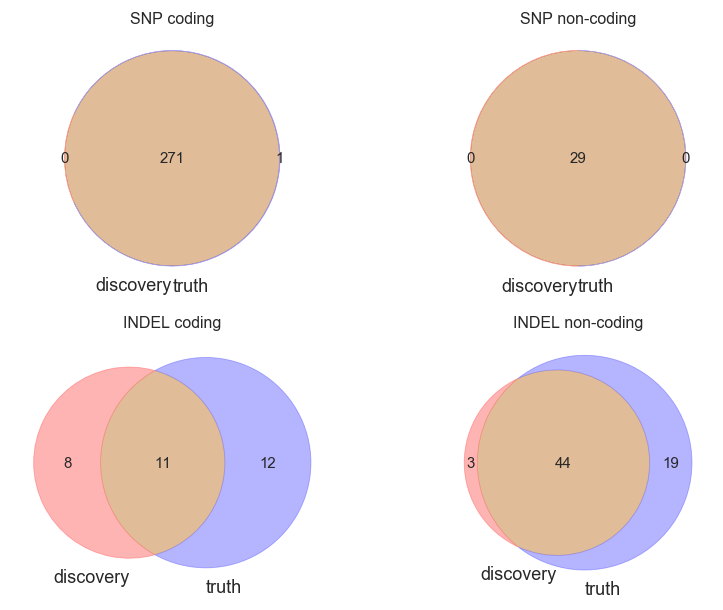

In [18]:
# bwamem_intractg 
# gatk_ug vs bcftools_multiallelic

tbl_variants_check1 = tabulate_variants_truth(alignment_method='bwamem_intractg',
                                              calling_method='gatk_ug',
                                              assembly='genbank_hb3_coding_sequences').cutout('truth').addfield('discovery', True)
tbl_variants_check2 = join_truth(tbl_variants_check1, 
                                 alignment_method='bwamem_intractg',
                                 calling_method='bcftools_multiallelic',
                                 assembly='genbank_hb3_coding_sequences',
                                 key=('CHROM', 'POS', 'REF', 'ALT'))
log(tbl_variants_check2.nrows())
tbl_variants_check2.valuecounts('gene').sort('gene').displayall()
tbl_variants_check2.eq('status', 'FP').display(5, tr_style=confusion_tr_style)
tbl_variants_check2.eq('status', 'FN').display(5, tr_style=confusion_tr_style)
analyse_confusion(tbl_variants_check2)

[vcfnp] 2016-03-08 22:44:30.652491 :: caching is disabled
[vcfnp] 2016-03-08 22:44:30.653398 :: building array
[vcfnp] 2016-03-08 22:44:30.716880 :: caching is disabled
[vcfnp] 2016-03-08 22:44:30.717474 :: building array
[vcfnp] 2016-03-08 22:44:30.782850 :: caching is disabled
[vcfnp] 2016-03-08 22:44:30.783397 :: building array
[vcfnp] 2016-03-08 22:44:30.825447 :: caching is disabled
[vcfnp] 2016-03-08 22:44:30.825928 :: building array
2016-03-08 22:44:35.139932 :: 387


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding
Pf3D7_01_v3,266073,A,ATT,None,None,2,INS,1,FN,PF3D7_0106300,False
Pf3D7_02_v3,297374,T,TA,None,None,1,INS,1,FN,PF3D7_0207400,False
Pf3D7_04_v3,137768,AT,A,None,None,-1,DEL,1,FN,PF3D7_0402300,False
Pf3D7_06_v3,130254,TA,T,None,None,-1,DEL,1,FN,None,False
Pf3D7_06_v3,132107,TA,T,None,None,-1,DEL,1,FN,None,False


0|svtype,1|n,2|TP,3|FP,4|FN,5|FDR,6|sensitivity
all,387,367,0,20,0.0,0.9483204134366925
SNP coding,272,272,0,0,0.0,1.0
SNP non-coding,29,29,0,0,0.0,1.0
INDEL coding,23,19,0,4,0.0,0.8260869565217391
INDEL non-coding,63,47,0,16,0.0,0.746031746031746


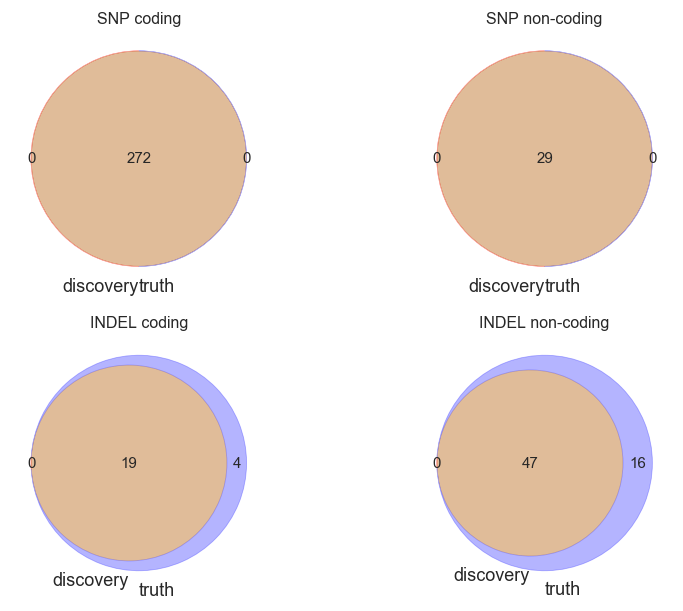

In [19]:
# bwamem_intractg 
# bcftools_consensus vs bcftools_multiallelic

tbl_variants_check1 = tabulate_variants_truth(alignment_method='bwamem_intractg',
                                              calling_method='bcftools_consensus',
                                              assembly='genbank_hb3_coding_sequences').cutout('truth').addfield('discovery', True)
tbl_variants_check2 = join_truth(tbl_variants_check1, 
                                 alignment_method='bwamem_intractg',
                                 calling_method='bcftools_multiallelic',
                                 assembly='genbank_hb3_coding_sequences',
                                 key=('CHROM', 'POS', 'REF', 'ALT'))
log(tbl_variants_check2.nrows())
tbl_variants_check2.eq('status', 'FP').display(5, tr_style=confusion_tr_style)
tbl_variants_check2.eq('status', 'FN').display(5, tr_style=confusion_tr_style)
analyse_confusion(tbl_variants_check2)

## 3D7 GATK versus Garimella

In [20]:
tbl_variants_3d7_gatk = tabulate_variants_gatk('3d7_hb3', 0)
tbl_variants_3d7_gatk

2016-03-08 22:44:36.500076 :: 3D7/PG0051-C/ERR019061
2016-03-08 22:44:36.972788 :: n_variants 109


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|discovery
Pf3D7_01_v3,108579,A,ATATT,4,INS,True
Pf3D7_01_v3,190317,CATAATA,C,-6,DEL,True
Pf3D7_01_v3,237483,AATAT,A,-4,DEL,True
Pf3D7_01_v3,273111,T,TTATA,4,INS,True
Pf3D7_01_v3,286838,AATATATATATAT,A,-12,DEL,True


[vcfnp] 2016-03-08 22:44:37.005491 :: caching is disabled
[vcfnp] 2016-03-08 22:44:37.005857 :: building array
[vcfnp] 2016-03-08 22:44:37.041260 :: caching is disabled
[vcfnp] 2016-03-08 22:44:37.041631 :: building array
2016-03-08 22:44:42.410329 :: 467


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding
Pf3D7_01_v3,237483,AATAT,A,-4,DEL,None,None,1,FP,None,False
Pf3D7_01_v3,273111,T,TTATA,4,INS,None,None,1,FP,PF3D7_0106400,False
Pf3D7_01_v3,289078,T,TTATATATATATATATA,16,INS,None,None,1,FP,None,False
Pf3D7_01_v3,294390,CATATATAT,C,-8,DEL,None,None,1,FP,PF3D7_0107000,False
Pf3D7_01_v3,319523,AATATAT,A,-6,DEL,None,None,1,FP,None,False


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding
Pf3D7_01_v3,102198,G,A,None,None,0,SNP,1,FN,PF3D7_0102200,True
Pf3D7_01_v3,191069,CA,C,None,None,-1,DEL,1,FN,PF3D7_0104300,True
Pf3D7_01_v3,202364,G,A,None,None,0,SNP,1,FN,None,False
Pf3D7_01_v3,219230,C,A,None,None,0,SNP,1,FN,None,False
Pf3D7_01_v3,273111,T,TTATATATATATATATATATATA,None,None,22,INS,1,FN,PF3D7_0106400,False


0|svtype,1|n,2|TP,3|FP,4|FN,5|FDR,6|sensitivity
all,467,33,23,411,0.4107142857142857,0.07432432432432433
SNP coding,45,0,3,42,1.0,0.0
SNP non-coding,219,1,0,218,0.0,0.0045662100456621
INDEL coding,27,7,2,18,0.2222222222222222,0.28
INDEL non-coding,176,25,18,133,0.4186046511627907,0.15822784810126583


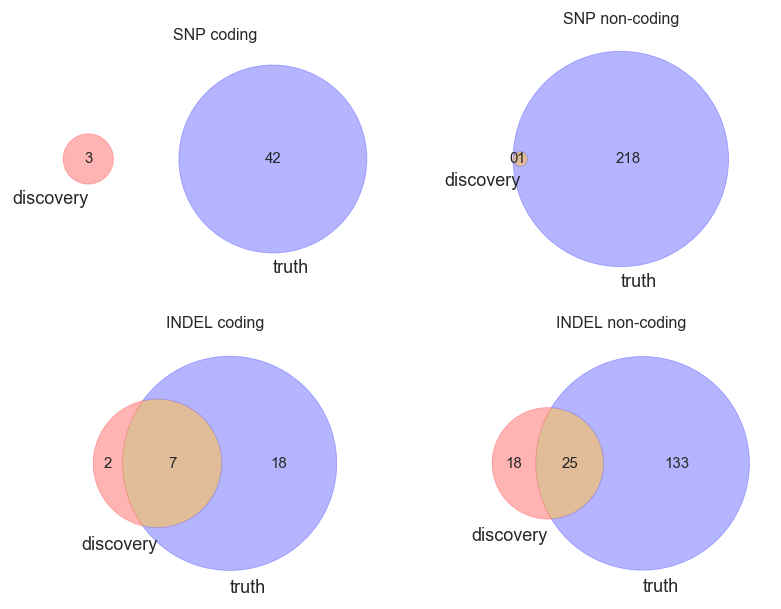

In [21]:
tbl_variants_3d7_gatk_vs_garimella_allele = join_truth(
    tbl_variants_3d7_gatk,
    alignment_method='bwamem_intractg', 
    calling_method='bcftools_multiallelic', 
    assembly='garimella_3d7_ERR019061_contigs',
    key=('CHROM', 'POS', 'REF', 'ALT')
)
log(tbl_variants_3d7_gatk_vs_garimella_allele.nrows())
tbl_variants_3d7_gatk_vs_garimella_allele.eq('status', 'FP').display(5, tr_style=confusion_tr_style)
tbl_variants_3d7_gatk_vs_garimella_allele.eq('status', 'FN').display(5, tr_style=confusion_tr_style)
analyse_confusion(tbl_variants_3d7_gatk_vs_garimella_allele)

## HB3(1) GATK versus Garimella

In [22]:
tbl_variants_hb31_gatk = tabulate_variants_gatk('3d7_hb3', 1)
tbl_variants_hb31_gatk

2016-03-08 22:44:43.749197 :: HB3/PG0052-C/ERR019054
2016-03-08 22:44:44.234426 :: n_variants 36635


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|discovery
Pf3D7_01_v3,93901,AATATATATAT,A,-10,DEL,True
Pf3D7_01_v3,94590,T,TATAC,4,INS,True
Pf3D7_01_v3,94993,CATATAT,C,-6,DEL,True
Pf3D7_01_v3,95518,G,T,0,SNP,True
Pf3D7_01_v3,95621,T,A,0,SNP,True


[vcfnp] 2016-03-08 22:44:44.286170 :: caching is disabled
[vcfnp] 2016-03-08 22:44:44.286552 :: building array
[vcfnp] 2016-03-08 22:44:44.761141 :: caching is disabled
[vcfnp] 2016-03-08 22:44:44.761517 :: building array
2016-03-08 22:50:31.973350 :: 36686


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding
Pf3D7_01_v3,103413,A,AAT,2,INS,None,None,1,FP,None,False
Pf3D7_01_v3,117342,AAT,A,-2,DEL,None,None,1,FP,None,False
Pf3D7_01_v3,122104,A,AATATAT,6,INS,None,None,1,FP,None,False
Pf3D7_01_v3,123313,C,CAT,2,INS,None,None,1,FP,None,False
Pf3D7_01_v3,123589,T,TTATA,4,INS,None,None,1,FP,None,False


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_svlen,7|truth_svtype,8|truth_coverage,9|status,10|gene,11|is_coding
Pf3D7_01_v3,101759,T,C,None,None,0,SNP,1,FN,PF3D7_0102200,True
Pf3D7_01_v3,101784,A,T,None,None,0,SNP,1,FN,PF3D7_0102200,True
Pf3D7_01_v3,117524,C,CAAAAGAAAAAAAGAA,None,None,15,INS,1,FN,None,False
Pf3D7_01_v3,123223,A,AT,None,None,1,INS,1,FN,None,False
Pf3D7_01_v3,123311,A,C,None,None,0,SNP,1,FN,None,False


0|svtype,1|n,2|TP,3|FP,4|FN,5|FDR,6|sensitivity
all,36686,23302,4705,8679,0.1679937158567501,0.7286201181951784
SNP coding,8884,6425,415,2044,0.06067251461988304,0.7586491911677884
SNP non-coding,6428,3524,115,2789,0.03160208848584776,0.5582132108347854
INDEL coding,3845,2382,486,977,0.1694560669456067,0.7091396248883596
INDEL non-coding,17529,10971,3689,2869,0.2516371077762619,0.7927023121387283


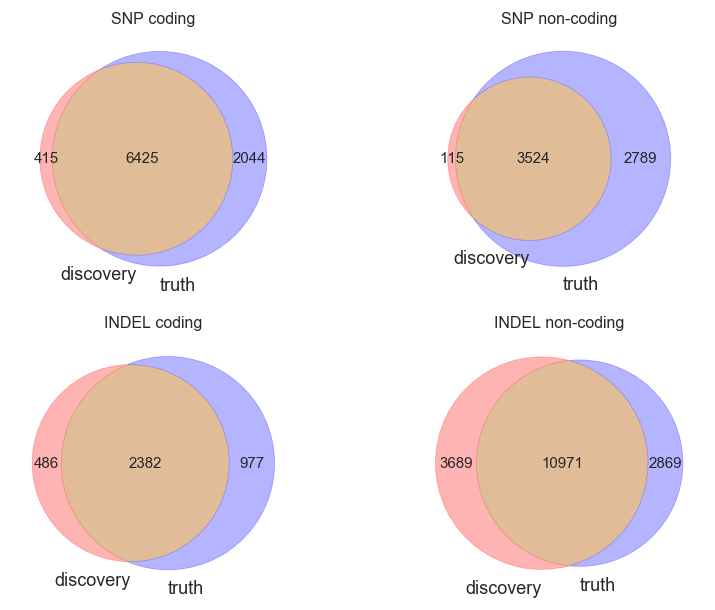

In [23]:
tbl_variants_hb31_gatk_vs_garimella_allele = join_truth(
    tbl_variants_hb31_gatk,
    alignment_method='bwamem_intractg', 
    calling_method='bcftools_multiallelic', 
    assembly='garimella_hb3_ERR019054_contigs',
    key=('CHROM', 'POS', 'REF', 'ALT')
)
log(tbl_variants_hb31_gatk_vs_garimella_allele.nrows())
tbl_variants_hb31_gatk_vs_garimella_allele.eq('status', 'FP').display(5, tr_style=confusion_tr_style)
tbl_variants_hb31_gatk_vs_garimella_allele.eq('status', 'FN').display(5, tr_style=confusion_tr_style)
analyse_confusion(tbl_variants_hb31_gatk_vs_garimella_allele)

## HB3(1) GATK vs GenBank coding sequences

In [24]:
tbl_variants_hb31_gatk_vs_genbank_site = join_truth(tbl_variants_hb31_gatk,
                                                    alignment_method='bwamem_intractg', 
                                                    calling_method='bcftools_consensus', 
                                                    assembly='genbank_hb3_coding_sequences',
                                                    key=('CHROM', 'POS'))
tbl_variants_hb31_gatk_vs_genbank_site.display(20, tr_style=confusion_tr_style)

[vcfnp] 2016-03-08 22:50:32.503672 :: caching is disabled
[vcfnp] 2016-03-08 22:50:32.504167 :: building array
[vcfnp] 2016-03-08 22:50:32.537002 :: caching is disabled
[vcfnp] 2016-03-08 22:50:32.537401 :: building array


0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_REF,7|truth_ALT,8|truth_svlen,9|truth_svtype,10|truth_coverage,11|status,12|gene,13|is_coding
Pf3D7_01_v3,265603,CAT,C,-2,DEL,CAT,C,-2,DEL,1,TP,PF3D7_0106300,False
Pf3D7_01_v3,266480,A,T,0,SNP,A,T,0,SNP,1,TP,PF3D7_0106300,True
Pf3D7_01_v3,266640,TCTC,T,-3,DEL,TCTC,T,-3,DEL,1,TP,PF3D7_0106300,True
Pf3D7_01_v3,267777,C,T,0,SNP,C,T,0,SNP,1,TP,PF3D7_0106300,True
Pf3D7_01_v3,269132,C,T,0,SNP,C,T,0,SNP,1,TP,PF3D7_0106300,True
Pf3D7_02_v3,290368,G,GATAT,4,INS,G,GATAT,4,INS,1,TP,PF3D7_0207300,False
Pf3D7_02_v3,290569,T,A,0,SNP,T,A,0,SNP,1,TP,PF3D7_0207300,True
Pf3D7_02_v3,290572,T,A,0,SNP,T,A,0,SNP,1,TP,PF3D7_0207300,True
Pf3D7_02_v3,290667,G,C,0,SNP,G,C,0,SNP,1,TP,PF3D7_0207300,True
Pf3D7_02_v3,291565,A,AATATATATATATAT,14,INS,A,AATATATATATATAT,14,INS,1,TP,PF3D7_0207300,False


In [25]:
tbl_variants_hb31_gatk_vs_genbank_site.valuecounts('gene').displayall()

0|gene,1|count,2|frequency
PF3D7_0930300,41,0.09534883720930233
None,38,0.08837209302325581
PF3D7_0709300,32,0.07441860465116279
PF3D7_1133400,29,0.06744186046511629
PF3D7_0220800,28,0.06511627906976744
PF3D7_0831600,25,0.05813953488372093
PF3D7_0709100,18,0.04186046511627907
PF3D7_0402300,15,0.03488372093023256
PF3D7_0207600,15,0.03488372093023256
PF3D7_1115700,15,0.03488372093023256


0|svtype,1|n,2|TP,3|FP,4|FN,5|FDR,6|sensitivity
all,430,267,63,100,0.19090909090909092,0.7275204359673024
SNP coding,312,217,40,55,0.1556420233463035,0.7977941176470589
SNP non-coding,32,12,3,17,0.2,0.41379310344827586
INDEL coding,26,7,7,12,0.5,0.3684210526315789
INDEL non-coding,60,31,13,16,0.29545454545454547,0.6595744680851063


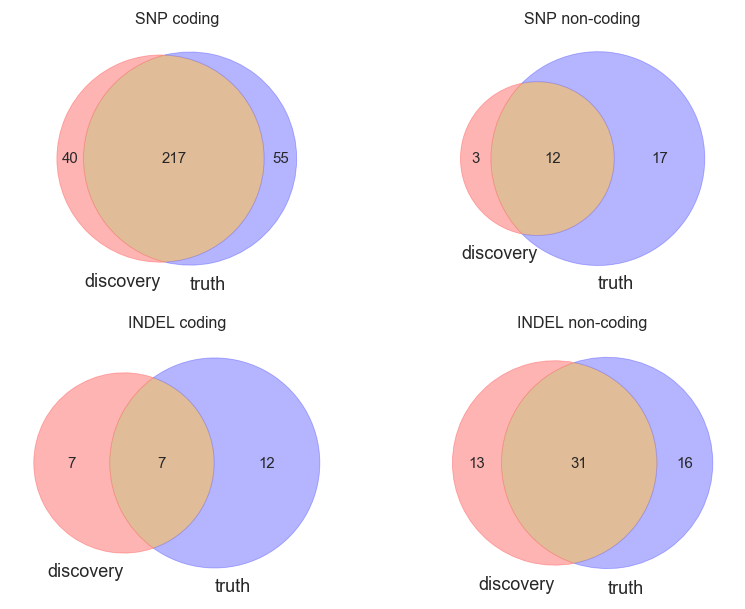

In [26]:
analyse_confusion(tbl_variants_hb31_gatk_vs_genbank_site)

In [27]:
tbl_variants_hb31_gatk_vs_genbank_site.select(lambda row: row.svtype in {'INS', 'DEL'} or row.truth_svtype in {'INS', 'DEL'}).displayall(tr_style=confusion_tr_style)

0|CHROM,1|POS,2|REF,3|ALT,4|svlen,5|svtype,6|truth_REF,7|truth_ALT,8|truth_svlen,9|truth_svtype,10|truth_coverage,11|status,12|gene,13|is_coding
Pf3D7_01_v3,265603,CAT,C,-2,DEL,CAT,C,-2,DEL,1,TP,PF3D7_0106300,False
Pf3D7_01_v3,266640,TCTC,T,-3,DEL,TCTC,T,-3,DEL,1,TP,PF3D7_0106300,True
Pf3D7_02_v3,290368,G,GATAT,4,INS,G,GATAT,4,INS,1,TP,PF3D7_0207300,False
Pf3D7_02_v3,291565,A,AATATATATATATAT,14,INS,A,AATATATATATATAT,14,INS,1,TP,PF3D7_0207300,False
Pf3D7_02_v3,292241,C,CATAT,4,INS,C,CATATAT,6,INS,1,TP,PF3D7_0207300,False
Pf3D7_02_v3,296350,AATATATAT,A,-8,DEL,AATATATAT,A,-8,DEL,1,TP,PF3D7_0207400,False
Pf3D7_02_v3,296617,A,AATATATATATATAT,14,INS,A,AATATATATATAT,12,INS,1,TP,PF3D7_0207400,False
Pf3D7_02_v3,297538,CATAT,C,-4,DEL,None,None,None,None,1,FP,PF3D7_0207400,False
Pf3D7_02_v3,297555,ATATAT,A,-5,DEL,None,None,None,None,1,FP,PF3D7_0207400,False
Pf3D7_02_v3,297556,TATA,T,-3,DEL,TATA,T,-3,DEL,1,TP,PF3D7_0207400,False
